In [1]:
import os, sys, time
import numpy as np
from numpy import sqrt, exp, pi, square
import pandas as pd
pd.options.mode.chained_assignment = None        # default='warn'
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d, UnivariateSpline
import warnings
warnings.filterwarnings('ignore')
from multihist import Histdd, Hist1d
from tqdm import tqdm
from multiprocessing import Pool
from contextlib import contextmanager

def plt_config(title=None, xlim=None, ylim=None, xlabel=None, ylabel=None, colorbar=False, sci=False):
    for field in ['title', 'xlim', 'ylim', 'xlabel', 'ylabel']:
        if eval(field) != None: getattr(plt, field)(eval(field))
    if isinstance(sci, str): plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if isinstance(colorbar,str): plt.colorbar(label=colorbar)
    elif colorbar: plt.colorbar(label = '$Number\ of\ Entries$')

@contextmanager
def initiate_plot(dimx=24, dimy=9):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    global fig; fig = plt.figure()
    yield
    plt.show()

@contextmanager
def timeit():
    start = time.time()
    yield
    stop = time.time()
    print('This took %.2f seconds' % (stop-start))
    time.sleep(0.5)

In [2]:
### hax ###
import hax
hax.__version__

hax.init(raw_data_access_mode = 'local',
         raw_data_local_path = ['/project/lgrandi/xenon1t/raw_for_waveforms/'], 
         main_data_paths= ['/project2/lgrandi/xenon1t/processed/pax_v6.8.0/',''],
         minitree_paths= ['/scratch/midway2/zhut/data/SingleScatter/data/minitrees/','/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0/'],
         pax_version_policy = 'loose',
         use_rundb=False,
         make_minitree=False,
        )

In [3]:
# For understanding background runs
run_name = '170419_0228'
my_dataset=8861

df = pd.read_pickle('/project2/lgrandi/zhut/data/compromise/pax_v6.8.0_none_sciencerun1_cpm/%s.pkl'%run_name)
df_long = df[df.eval('(s2>1e6) & (~CutS2Width)')]
df_normal = df[df.eval('(s2>1e6) & (CutS2Width)')]
df_deep = df[df.eval('(z_3d_nn<-80) & (s2 < 8000)')]

In [4]:
"""# For understanding Kr runs
run_name = '170619_1540'
my_dataset=10587

flist = os.listdir(os.path.join('/project/lgrandi/xenon1t/raw_for_waveforms/', run_name))
event_range =[np.array(f.split('-')[2:4], dtype=int) for f in flist]

df = pd.read_pickle('/project2/lgrandi/zhut/data/cleaned/pax_v6.8.0_Kr83m_sciencerun1/%s.pkl'%run_name)
cache = [df[(df.event_number>=er[0]) & (df.event_number<=er[1])] for er in event_range]
df = pd.concat(cache)

df_normal = df[df.eval('(cs1 < 1e3) & (cs2<1e5) & (cs2>3e3)')]"""

In [7]:
# For reading pax configs
from pax import units
from pax import configuration

config_values = dict()

conf_ = hax.utils.combine_pax_configs(
    configuration.load_configuration(['_base']),
    configuration.load_configuration(['_base'])
    )
for key in conf_.keys(): config_values.update(conf_[key])

conf_ = configuration.load_configuration(('XENON1T'))
for key in conf_.keys(): config_values.update(conf_[key])

conf_ = hax.utils.combine_pax_configs(
     configuration.load_configuration(['XENON1T']),
    hax.runs.get_run_info(my_dataset, 'processor'))
for key in conf_.keys(): config_values.update(conf_[key])

In [9]:
# Redefine Some function from pax/pax/dsputils.py for hit level spliting & local minimum clusting

import numba
import numpy as np

from pax import units, exceptions
from pax.datastructure import Hit

def smooth_lowess(y, x, frac=1.0/2.0):
    """
    Smoothing using lowess
    return y expectation at input x positions
    Of course there are much better material on this
    But I learned from http://astrostatistics.psu.edu/su18/18Lectures/Regression.pdf
    """
    n = len(x)
    neighborhood = np.ceil(frac*n)

    # w_ij = (1-abs((x_j-x_i)/(neighborhood))**3)**3 if x_j IN the neighborhood of x_i
    # w_ij = 0 if x_j in NOT IN the neighborhood of x_i
    # Of corse w_ij is symmetric
    w = np.clip(np.abs((x[:, None]-x[None, :])/neighborhood), 0.0, 1.0)
    w = (1-w**3)**3

    delta = np.ones(n)
    # We use matrices to speed up calculation but memory costly
    xmatrix = np.tile(x, n).reshape(n, n)  # x_*j
    ymatrix = np.tile(y, n).reshape(n, n)  # y_*j

    wmatrix = w * np.tile(delta, n).reshape(n, n)   # w_ij * delta_*j

    # Here capital case X Y has nothing to do with lower case x y,

    # Derived from linear regression in order to solve 'm' and 'k'
    # Ya_i=m_i+k_i*Xa_i and Yb_i=m_i+k_i*Xb_i
    Ya = np.sum(wmatrix * ymatrix, axis=1) / np.sum(wmatrix, axis=1)
    Xa = np.sum(wmatrix * xmatrix, axis=1) / np.sum(wmatrix, axis=1)
    Yb = np.sum(wmatrix * xmatrix * ymatrix, axis=1) / np.sum(wmatrix * xmatrix, axis=1)
    Xb = np.sum(wmatrix * xmatrix * xmatrix, axis=1) / np.sum(wmatrix * xmatrix, axis=1)

    yestimate = Ya + (Yb - Ya) / (Xb - Xa) * (x - Xa)
    residuals = y - yestimate
    s = np.median(np.abs(residuals))
    delta = np.clip(residuals / (6.0 * s), -1, 1)
    delta = (1 - delta ** 2) ** 2

    return yestimate

def find_intervals_above_threshold(w, threshold, result_buffer):
    """Fills result_buffer with l, r bounds of intervals in w > threshold.
    :param w: Waveform to do hitfinding in
    :param threshold: Threshold for including an interval
    :param result_buffer: numpy N*2 array of ints, will be filled by function.
                          if more than N intervals are found, none past the first N will be processed.
    :returns : number of intervals processed
    Boundary indices are inclusive, i.e. the right boundary is the last index which was > threshold
    """
    result_buffer_size = len(result_buffer)
    last_index_in_w = len(w) - 1

    in_interval = False
    current_interval = 0
    current_interval_start = -1

    for i, x in enumerate(w):

        if not in_interval and x > threshold:
            # Start of an interval
            in_interval = True
            current_interval_start = i

        if in_interval and (x <= threshold or i == last_index_in_w):
            # End of the current interval
            in_interval = False

            # The interval ended just before this index
            # Unless we ended ONLY because this is the last index, then the interval ends right here
            itv_end = i - 1 if x <= threshold else i

            # Split interval if the interval >350 samples
            # Use lowess to smooth raw waveform and split at relative minima.
            if itv_end - current_interval_start > 350:
                broader_interval_start = current_interval_start

                _w = w[broader_interval_start:itv_end][::2].copy()
                _w = smooth_lowess(_w, np.arange(len(_w)), frac=30/len(_w))
                dw = _w[1:] - _w[:-1]
                for j in np.where((np.hstack((dw, -1)) > 0) & (np.hstack((1, dw)) <= 0))[0]:
                    result_buffer[current_interval, 0] = current_interval_start
                    result_buffer[current_interval, 1] = j*2+broader_interval_start

                    current_interval_start = j*2+broader_interval_start+1
                    current_interval += 1

            # Add bounds to result buffer
            result_buffer[current_interval, 0] = current_interval_start
            result_buffer[current_interval, 1] = itv_end
            current_interval += 1

            if current_interval == result_buffer_size:
                break

    n_intervals = current_interval      # No +1, as current_interval was incremented also when the last interval closed
    return n_intervals

#from pax import dsputils
#find_intervals_above_threshold = dsputils.find_intervals_above_threshold

In [12]:
# There is nothing to change about FindHits
# Only to swich out dsputils.find_intervals_above_threshold to the find_intervals_above_threshold defined above

import numpy as np
import numba

from pax import plugin, datastructure, dsputils


class MyFindHits(plugin.TransformPlugin):
    """Finds hits in pulses, proceeding in a few stages
        1. The waveform is baseline-corrected (with baseline as determined by PulseProperties.PulseProperties)
        2. Hits are found based on a threshold, which can be set on three different quantities (see below)
        3. Hits are extended left and right depending on the left_extension and right_extension settings.

    Types of thresholds:

    1) Height over noise threshold
       This threshold operates on the height above baseline / noise level
       The noise level is deteremined in each pulse as
         (<(w - baseline)**2>)**0.5
       with the average running *only* over samples < baseline!

    2) Absolute ADC counts above baseline
       If there is measurable noise in the waveform, you don't want the thresholds to fall to 0 and crash pax.
       This happens for pulses constant on initial_baseline_samples.
       Please use this as a deep fallback only, unless you know what mess you're getting yourself into!

    3) - Height / minimum
       Using this threshold protects you against sudden up & down fluctuations, especially in large pulses
       However, keep in mind that one large downfluctuation will cause a sensitivity loss throughout an entire pulse;
       if you have ZLE off, this may be a bad idea...
       This threshold operates on the (-) height above baseline / height below baseline of the lowest sample in pulse

    The threshold is computed and stored per pulse.
    Here high/positive means 'signal like' (i.e. the PMT voltage becomes more negative). If multiple thresholds are
    given, the highest is used.

    Edge case:

    *) After large peaks the zero-length encoding can fail, making a huge pulse with many hits.
       If more than max_hits_per_pulse hits are found in a pulse, the rest will be ignored.
       If this threshold is set too low, you risk missing some hits in such events.
       If set too high, it will degrade performance. Don't set to infinity, we need to allocate memory for this...

    Debugging tip:
    If you get an error from one of the numba methods in this plugin (exception from native function blahblah)
    Try commenting the @jit decorators, which will run a slow, pure-python version of the methods,
    allowing you to debug. Don't forget to re-enable the @jit -- otherwise it will run quite slow!
    """

    def startup(self):
        c = self.config

        self.max_hits_per_pulse = c['max_hits_per_pulse']
        self.reference_baseline = self.config['digitizer_reference_baseline']

        self.always_find_single_hit = self.config.get('always_find_single_hit')

    def transform_event(self, event):
        dt = self.config['sample_duration']
        hits_per_pulse = []

        left_extension = self.config['left_extension'] // dt
        right_extension = self.config['right_extension'] // dt

        # Allocate numpy arrays to hold numba hitfinder results
        # -1 is a placeholder for values that should never appear (0 would be bad as it often IS a possible value)
        hit_bounds_buffer = -1 * np.ones((self.max_hits_per_pulse, 2), dtype=np.int64)
        hits_buffer = np.zeros(self.max_hits_per_pulse, dtype=datastructure.Hit.get_dtype())

        for pulse_i, pulse in enumerate(event.pulses):
            start = pulse.left
            stop = pulse.right
            channel = pulse.channel
            pmt_gain = self.config['gains'][channel]

            # Check the pulse properties have been computed
            if np.isnan(pulse.minimum):
                raise RuntimeError("Attempt to perform hitfinding on pulses whose properties have not been computed!")

            # Retrieve waveform as floats: needed to subtract baseline (which can be in-between ADC counts)
            w = pulse.raw_data.astype(np.float64)

            # Subtract the baseline and invert(so hits point up from baseline)
            w = self.reference_baseline - w
            w -= pulse.baseline

            # Don't do hitfinding in dead channels, pulse property computation was enough
            # Could refactor pulse property computation to separate plugin,
            # but that would mean waveform has to be converted to floats twice
            if pmt_gain == 0:
                continue

            # Compute hitfinder threshold to use
            # Rounding down is ok, since hitfinder uses >, not >= for threshold crossing testing.
            pulse.hitfinder_threshold = int(max(self.config['height_over_noise_threshold'] * pulse.noise_sigma,
                                                self.config['absolute_adc_counts_threshold'],
                                                - self.config['height_over_min_threshold'] * pulse.minimum))
            if self.always_find_single_hit:
                # The config specifies a single range to integrate. Useful for gain calibration
                hit_bounds_buffer[0] = self.always_find_single_hit
                n_hits_found = 1

            else:
                # Call the numba hit finder -- see its docstring for description
                n_hits_found = find_intervals_above_threshold(w,
                                                                       threshold=float(pulse.hitfinder_threshold),
                                                                       result_buffer=hit_bounds_buffer)

            # Only view the part of hit_bounds_buffer that contains hits found in this event
            # The rest of hit_bounds_buffer contains -1's or stuff from previous pulses
            pulse.n_hits_found = n_hits_found
            hit_bounds_found = hit_bounds_buffer[:n_hits_found]

            if self.always_find_single_hit:
                central_bounds = hit_bounds_found
            else:
                # Extend the boundaries of each hit, to be sure we integrate everything.
                # The original bounds are preserved: they are used in clustering
                central_bounds = hit_bounds_found.copy()
                dsputils.extend_intervals(w, hit_bounds_found, left_extension, right_extension)

            # If no hits were found, this is a noise pulse: update the noise pulse count
            if n_hits_found == 0:
                event.noise_pulses_in[channel] += 1
                # Don't 'continue' to the next pulse! There's stuff left to do!
            elif n_hits_found >= self.max_hits_per_pulse:
                self.log.debug("Pulse %s-%s in channel %s has more than %s hits. "
                               "This usually indicates a zero-length encoding breakdown after a very large S2. "
                               "Further hits in this pulse have been ignored." % (start, stop, channel,
                                                                                  self.max_hits_per_pulse))

            # Store the found hits in the datastructure
            # Convert area, noise_sigma and height from adc counts -> pe
            adc_to_pe = dsputils.adc_to_pe(self.config, channel)
            noise_sigma_pe = pulse.noise_sigma * adc_to_pe

            # If the DAQ pulse was ADC-saturated (clipped), the raw waveform dropped to 0,
            # i.e. we went digitizer_reference_baseline above the reference baseline
            # i.e. we went digitizer_reference_baseline - pulse.baseline above baseline
            # 0.5 is needed to avoid floating-point rounding errors to cause saturation not to be reported
            # Somehow happens only when you use simulated data -- apparently np.clip rounds slightly different
            saturation_threshold = self.reference_baseline - pulse.baseline - 0.5

            build_hits(w, hit_bounds_found, hits_buffer,
                       adc_to_pe, channel, noise_sigma_pe, dt, start, pulse_i, saturation_threshold, central_bounds)
            hits = hits_buffer[:n_hits_found].copy()
            hits_per_pulse.append(hits)

        if len(hits_per_pulse):
            event.all_hits = np.concatenate(hits_per_pulse)

            if not self.always_find_single_hit:
                # Remove hits with 0 or negative area (very rare, but possible due to rigid integration bound)
                # In always-find-single-hit mode (for PMT calibrations) this is undesirable
                event.all_hits = event.all_hits[event.all_hits['area'] > 0]

            self.log.debug("Found %d hits in %d pulses" % (len(event.all_hits), len(event.pulses)))
        else:
            self.log.warning("Event has no pulses??!")

        return event


@numba.jit(numba.void(numba.float64[:], numba.int64[:, :],
                      numba.from_dtype(datastructure.Hit.get_dtype())[:],
                      numba.float64, numba.int64, numba.float64, numba.int64, numba.int64, numba.int64, numba.float64,
                      numba.int64[:, :]),
           nopython=True)
def build_hits(w, hit_bounds,
               hits_buffer,
               adc_to_pe, channel, noise_sigma_pe, dt, start, pulse_i, saturation_threshold,
               central_bounds):
    """Populates hits_buffer with properties from hits indicated by hit_bounds.
        hit_bounds should be a numpy array of (left, right) bounds (inclusive) in w
    Returns nothing.
    """
    for hit_i in range(len(hit_bounds)):
        amplitude = -999.9
        argmax = -1
        area = 0.0
        center = 0.0
        deviation = 0.0
        saturation_count = 0
        left = hit_bounds[hit_i, 0]
        right = hit_bounds[hit_i, 1]
        for i, x in enumerate(w[left:right + 1]):
            if x > amplitude:
                amplitude = x
                argmax = i
            if x > saturation_threshold:
                saturation_count += 1
            area += x
            center += x * i

        # During gain calibration, or if the low threshold is set to negative values,
        # the hitfinder can include regions with negative amplitudes
        # In rare cases this can make the area come out at 0, in which case this code
        # would throw a divide by zero exception.
        if area != 0:
            center /= area
            for i, x in enumerate(w[left:right + 1]):
                deviation += x * abs(i - center)
            deviation /= area

        # Store the hit properties
        hits_buffer[hit_i].channel = channel
        hits_buffer[hit_i].found_in_pulse = pulse_i
        hits_buffer[hit_i].noise_sigma = noise_sigma_pe
        hits_buffer[hit_i].left = left + start
        hits_buffer[hit_i].right = right + start
        hits_buffer[hit_i].sum_absolute_deviation = deviation
        hits_buffer[hit_i].center = (start + left + center) * dt
        hits_buffer[hit_i].index_of_maximum = start + left + argmax
        hits_buffer[hit_i].n_saturated = saturation_count
        hits_buffer[hit_i].area = area * adc_to_pe
        hits_buffer[hit_i].height = w[argmax + left] * adc_to_pe

        hits_buffer[hit_i].left_central = central_bounds[hit_i][0] + start
        hits_buffer[hit_i].right_central = central_bounds[hit_i][1] + start

In [27]:
# Redefine local minimum clustering
# Only changed find_split_points
# Add Tailsperation

from pax import plugin, datastructure, dsputils
from scipy.stats import norm
import numpy as np
import logging
from pax.plugins.signal_processing.HitFinder import build_hits
#log = logging.getLogger('LocalMinimumClusteringHelpers')


class MyLocalMinimumClustering(plugin.ClusteringPlugin):

    def cluster_peak(self, peak):
        if peak.type == 'lone_hit':
            return [peak]
        w = self.event.get_sum_waveform(peak.detector).samples[peak.left:peak.right + 1]
        split_points = list(find_split_points(w,
                                              min_height=self.config['min_height'],
                                              min_ratio=self.config.get('min_ratio', 3)))
        if not len(split_points):
            return [peak]
        else:
            self.log.debug("Splitting %d-%d into %d peaks" % (peak.left, peak.right, len(split_points) + 1))
            return list(self.split_peak(peak, split_points))

    def finalize_event(self):
        # Update the event.all_hits field (for plotting), since new hits were created
        # Note we must separately get out the rejected hits, they are not in any peak...
        self.event.all_hits = np.concatenate([p.hits for p in self.event.peaks] +
                                             [self.event.all_hits[self.event.all_hits['is_rejected']]])

        # Restores order after shenanigans here
        # Important if someone uses (dict_)group_by from recarray tools later
        # As is done, for example in the hitfinder diagnostic plots... if you don't do this you get really strange
        # things there (missing hits were things were split, which makes you think there is a bug
        # in LocalMinimumClustering, but actually there isn't...)
        self.event.all_hits.sort(order='found_in_pulse')

    def split_peak(self, peak, split_points):
        """Yields new peaks split from peak at split_points = sample indices within peak
        Samples at the split points will fall to the right (so if we split [0, 5] on 2, you get [0, 1] and [2, 5]).
        Hits that straddle a split point are themselves split into two hits: peak.hits is updated.
        """
        # First, split hits that straddle the split points
        # Hits may have to be split several times; for each split point we modify the 'hits' list, splitting only
        # the hits we need.
        hits = peak.hits
        for x in split_points:
            x += peak.left   # Convert to index in event

            # Select hits that must be split: start before x and end after it.
            selection = (hits['left'] <= x) & (hits['right'] > x)
            hits_to_split = hits[selection]

            # new_hits will be a list of hit arrays, which we concatenate later to make the new 'hits' list
            # Start with the hits that don't have to be split: we definitely want to retain those!
            new_hits = [hits[True ^ selection]]

            for h in hits_to_split:
                pulse_i = h['found_in_pulse']
                pulse = self.event.pulses[pulse_i]

                # Get the pulse waveform in ADC counts above baseline (because it's what build_hits expect)
                baseline_to_subtract = self.config['digitizer_reference_baseline'] - pulse.baseline
                w = baseline_to_subtract - pulse.raw_data.astype(np.float64)

                # Use the hitfinder's build_hits to compute the properties of these hits
                # Damn this is ugly... but at least we don't have duplicate property computation code
                hits_buffer = np.zeros(2, dtype=datastructure.Hit.get_dtype())
                adc_to_pe = dsputils.adc_to_pe(self.config, h['channel'])
                hit_bounds = np.array([[h['left'], x], [x+1, h['right']]], dtype=np.int64)
                hit_bounds -= pulse.left   # build_hits expects hit bounds relative to pulse start
                build_hits(w,
                           hit_bounds=hit_bounds,
                           hits_buffer=hits_buffer,
                           adc_to_pe=adc_to_pe,
                           channel=h['channel'],
                           noise_sigma_pe=pulse.noise_sigma * adc_to_pe,
                           dt=self.config['sample_duration'],
                           start=pulse.left,
                           pulse_i=pulse_i,
                           saturation_threshold=self.config['digitizer_reference_baseline'] - pulse.baseline - 0.5,
                           central_bounds=hit_bounds)       # TODO: Recompute central bounds in an intelligent way...

                # Remove hits with 0 or negative area (very rare, but possible due to rigid integration bound)
                hits_buffer = hits_buffer[hits_buffer['area'] > 0]

                new_hits.append(hits_buffer)

            # Now remake the hits list, then go on to the next peak.
            hits = np.concatenate(new_hits)

        # Next, split the peaks, sorting hits to the right peak by their maximum index.
        # Iterate over left, right bounds of the new peaks
        boundaries = list(zip([0] + [y+1 for y in split_points], split_points + [float('inf')]))
        for left, right in boundaries:
            # Convert to index in event
            left += peak.left
            right += peak.left

            # Select hits which have their maximum within this peak bounds
            # The last new peak must also contain hits at the right bound (though this is unlikely to happen)
            hs = hits[(hits['index_of_maximum'] >= left) &
                      (hits['index_of_maximum'] <= right)]

            if not len(hs):
                # Hits have probably been removed by area > 0 condition
                self.log.info("Localminimumclustering requested creation of peak %s-%s without hits. "
                              "This is a possible outcome if there are large oscillations in one channel, "
                              "but it should be very rare." % (left, right))
                continue

            right = right if right < float('inf') else peak.right

            if not len(hs):
                raise RuntimeError("Attempt to create a peak without hits in LocalMinimumClustering!")

            yield self.build_peak(hits=hs, detector=peak.detector, left=left, right=right)


def find_split_points(w, min_height, min_ratio):
    """"Finds local minima in w,
    whose peaks to the left and right both satisfy:
      - larger than minimum + min_height
      - larger than minimum * min_ratio # No longer required
    """
    if np.max(w) < min_height:
        return []

    # Smooth sum waveform, then use first and sign of second order dirivitive
    # to locate minima and maxima
    left = int(np.clip(np.where(w > min_height)[0][0]-500, 0, np.inf))
    right = int(np.clip(np.where(w > min_height)[0][-1]+500, 0, len(w)))

    _w = smooth_lowess(w[left:right], np.arange(right-left), frac=60/(right-left))
    dw = np.diff(_w, n=1)
    minima = np.where((np.hstack((dw, -1)) > 0) & (np.hstack((1, dw)) <= 0))[0]
    maxima = np.where((np.hstack((dw, 1)) < 0) & (np.hstack((-1, dw)) >= 0))[0]

    # We don't care about minima if it don't have maxima on both side
    # This automatically make one less minima then maxima
    if len(maxima) < 2:
        return []
    minima = minima[(minima > maxima[0]) & (minima < maxima[-1])]

    # We look for the last minima between big peaks
    good_minima = [int(minima[ix]+left) for ix in range(len(minima))
                   if ((_w[maxima][ix+1] - _w[minima][ix] > min_height)
                       & any(_w[maxima][:ix+1] - _w[minima][ix] > min_height))]

    return good_minima


class MyTailSeparation(MyLocalMinimumClustering):

    def cluster_peak(self, peak):
        if peak.type == 'lone_hit':
            return [peak]
        w = self.event.get_sum_waveform(peak.detector).samples[peak.left:peak.right + 1]
        split_points = list(find_tail_point(w,
                                            min_height=self.config['min_height'],
                                            ratio=self.config['tail_cutoff_ratio']))
        if not len(split_points):
            return [peak]
        else:
            self.log.debug("Splitting %d-%d into %d peaks" % (peak.left, peak.right, len(split_points) + 1))
            return list(self.split_peak(peak, split_points))


def find_tail_point(w, min_height, ratio):

    if np.max(w) < min_height:
        return []

    # Quick fit to the waveform and locate tail position
    ix = np.arange(len(w))

    # Use center population to estimate mean and sigma
    cnt = w > 0.02*np.max(w)
    mean = np.sum(ix[cnt]*w[cnt])/np.sum(w[cnt])
    sigma = (np.sum((ix[cnt]-mean)**2*w[cnt])/np.sum(w[cnt]))**0.5

    # Use estimated mean and sigma to find amplitude
    amp = np.sum(w[cnt]*norm.pdf(ix[cnt], mean, sigma))/np.sum(norm.pdf(ix[cnt], mean, sigma)**2)

    # Define tail by waveform height drop below certain ratio of amplitude
    tail = np.where(w < ratio*amp)[0]
    tail = tail[(tail > mean+2*sigma) & (tail != len(w))]

    if len(tail) > 0:
        return tail[:1]
    else:
        return []


In [28]:
config_values['s1_risetime_threshold'] = 70
config_values['s1_width_threshold'] = 300
config_values['max_gap_size_in_cluster'] = 3500

# Additional
config_values['tail_cutoff_ratio'] = 0.00005

In [29]:
############## Plotting while processing #######################
def plot_3d_waveform(event, xlim):
    if len(event.peaks):
        
        with initiate_plot(20,6):
            ax = fig.add_subplot(111)
            plt_config(ylim=[-15,15])
            axt = ax.twinx()
            plt_config(ylim=[0,248*2])

            # Looping over events ###################
            for peak in event.peaks:
                if peak.detector != 'tpc': continue
                w = event.get_sum_waveform(peak.detector).samples[peak.left:peak.right + 1]
                
                # For a peak with desired condition (can be large, can be time) copy what you want out
                # I name it CAPTURE, can be an array, value, or dictionary if you want
                if np.max(w)>100:
                    global CAPTURE
                    CAPTURE = w.copy()

                wave = w.copy()
                wave[wave>10] = np.log10(wave[wave>10])+9
                line = ax.plot((np.arange(len(w))+peak.left)/100, wave, ls='-', lw=1.0)

                hits = pd.DataFrame(peak.hits)
                hits = hits[(hits.channel<248) & (hits.area>2)]
                axt.scatter(hits.index_of_maximum/100, hits.channel, 
                            color=line[0].get_color(), edgecolor='none', s=np.clip(hits.area**0.5,5,30))

            plt_config(xlim=xlim)

In [32]:
# MAIN PART
# Process raw data from the start till finish building peaks

from pax.plugins.signal_processing import CheckPulses, PulseProperties, DesaturatePulses, HitFinder, BuildPeaks, SumWaveform
from pax.plugins.peak_processing import RejectNoiseHits, LocalMinimumClustering, NaturalBreaksClustering

import pprint

class SignalProcessing(plugin.TransformPlugin):
    """
    I use this class to test all the plugins.
    If you look at plugin.TransformPlugin you will see that to init
    you will need to put in (self, config_values, processor)
    """
    
    def transform_event(self, event, switch_out=False, xlim=[900, 1800]):
        """Frist config values from XENON1T.ini provides the order of original plugins """
        run_till_step = 11
        plugin_list = self.config['dsp'][:run_till_step]
        
        """We don't need this one"""
        plugin_list.remove('HitfinderDiagnosticPlots.HitfinderDiagnosticPlots')
        
        """Here switch something if I desire to, so that compare between original and update is easy"""
        if switch_out:
            switch = plugin_list.index('HitFinder.FindHits')
            plugin_list[switch] = ('MyFindHits')
            switch = plugin_list.index('LocalMinimumClustering.LocalMinimumClustering')
            plugin_list[switch] = ('MyLocalMinimumClustering')
            plugin_list.insert(switch+1, 'MyTailSeparation')
            
        pprint.pprint(plugin_list)
        
        """Plot waveform for each step, Disable it if you find it too slow"""
        for ix, p in enumerate(plugin_list):
            p = eval(p)(self.config, self.processor)
            p.transform_event(event)
            if ix > 3:
                print(p.__class__.__name__)
                plot_3d_waveform(event, xlim)
        
        return event

processor MainProcess L66 INFO This is PAX version 6.9.0, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw_for_waveforms/170419_0228/XENON1T-8861-000000000-000000999-000001000.zip (number 1/20 in folder) for reading


['CheckPulses.SortPulses',
 'PulseProperties.PulseProperties',
 'CheckPulses.CheckBoundsAndCount',
 'DesaturatePulses.DesaturatePulses',
 'MyFindHits',
 'SumWaveform.SumWaveform',
 'BuildPeaks.GapSizeClustering',
 'RejectNoiseHits.RejectNoiseHits',
 'MyLocalMinimumClustering',
 'MyTailSeparation',
 'NaturalBreaksClustering.NaturalBreaksClustering']
MyFindHits
SumWaveform
GapSizeClustering


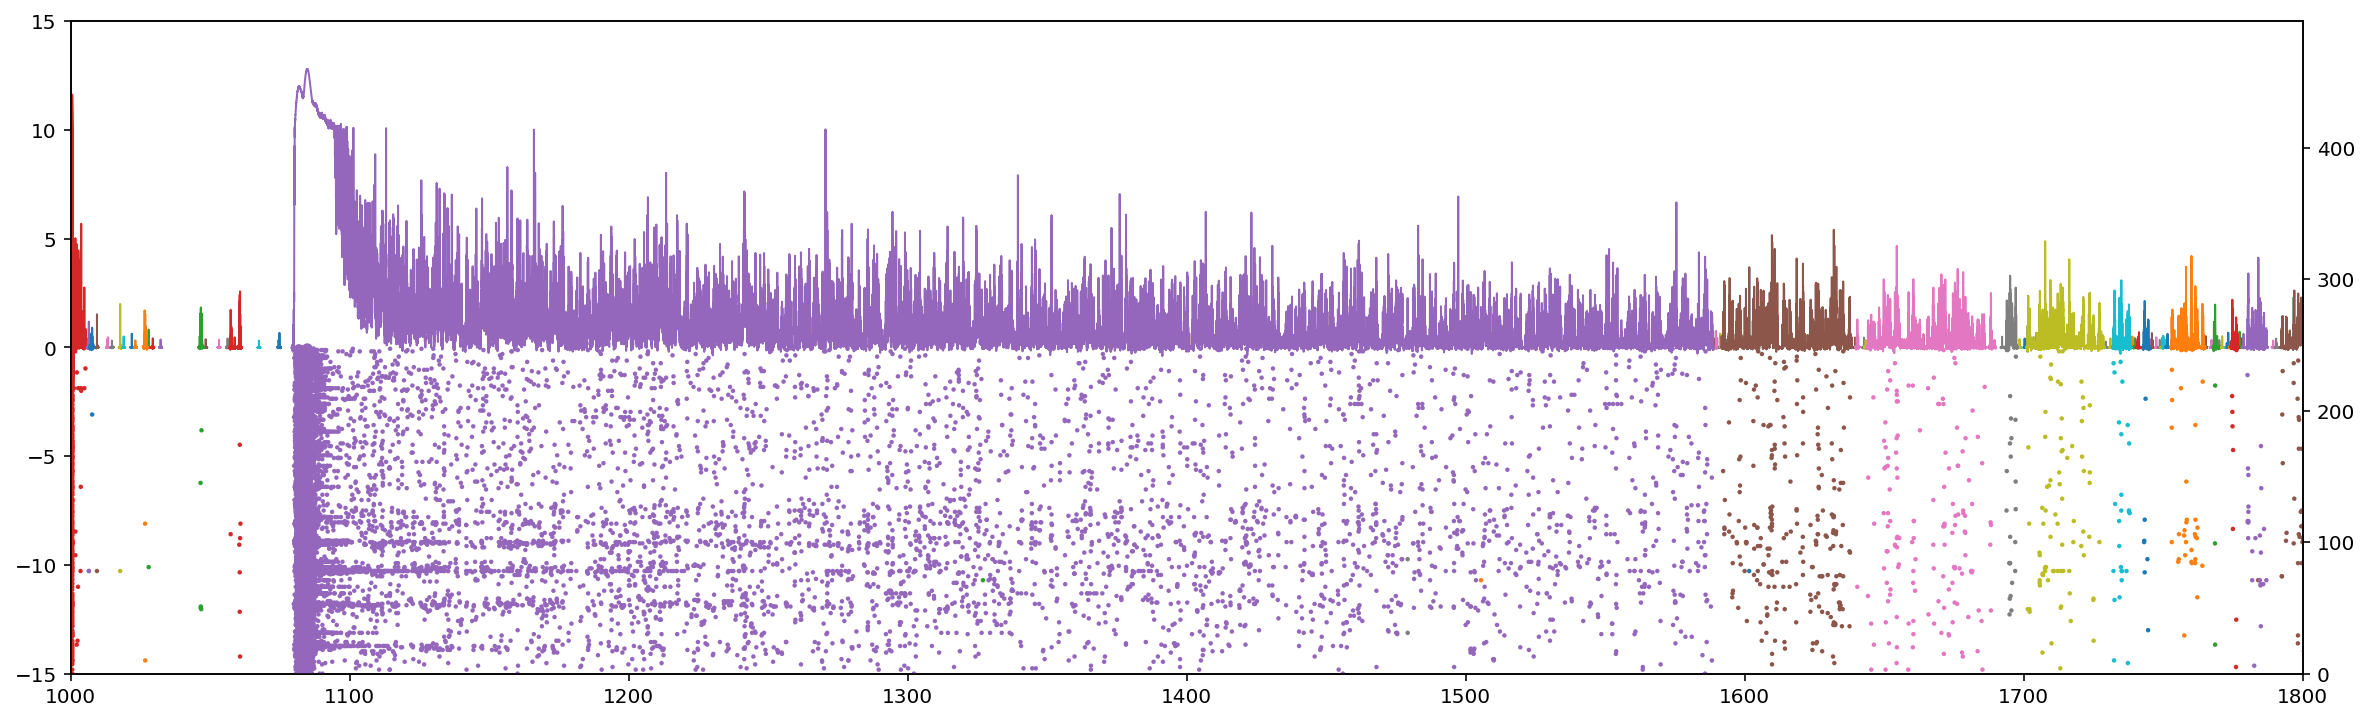

RejectNoiseHits


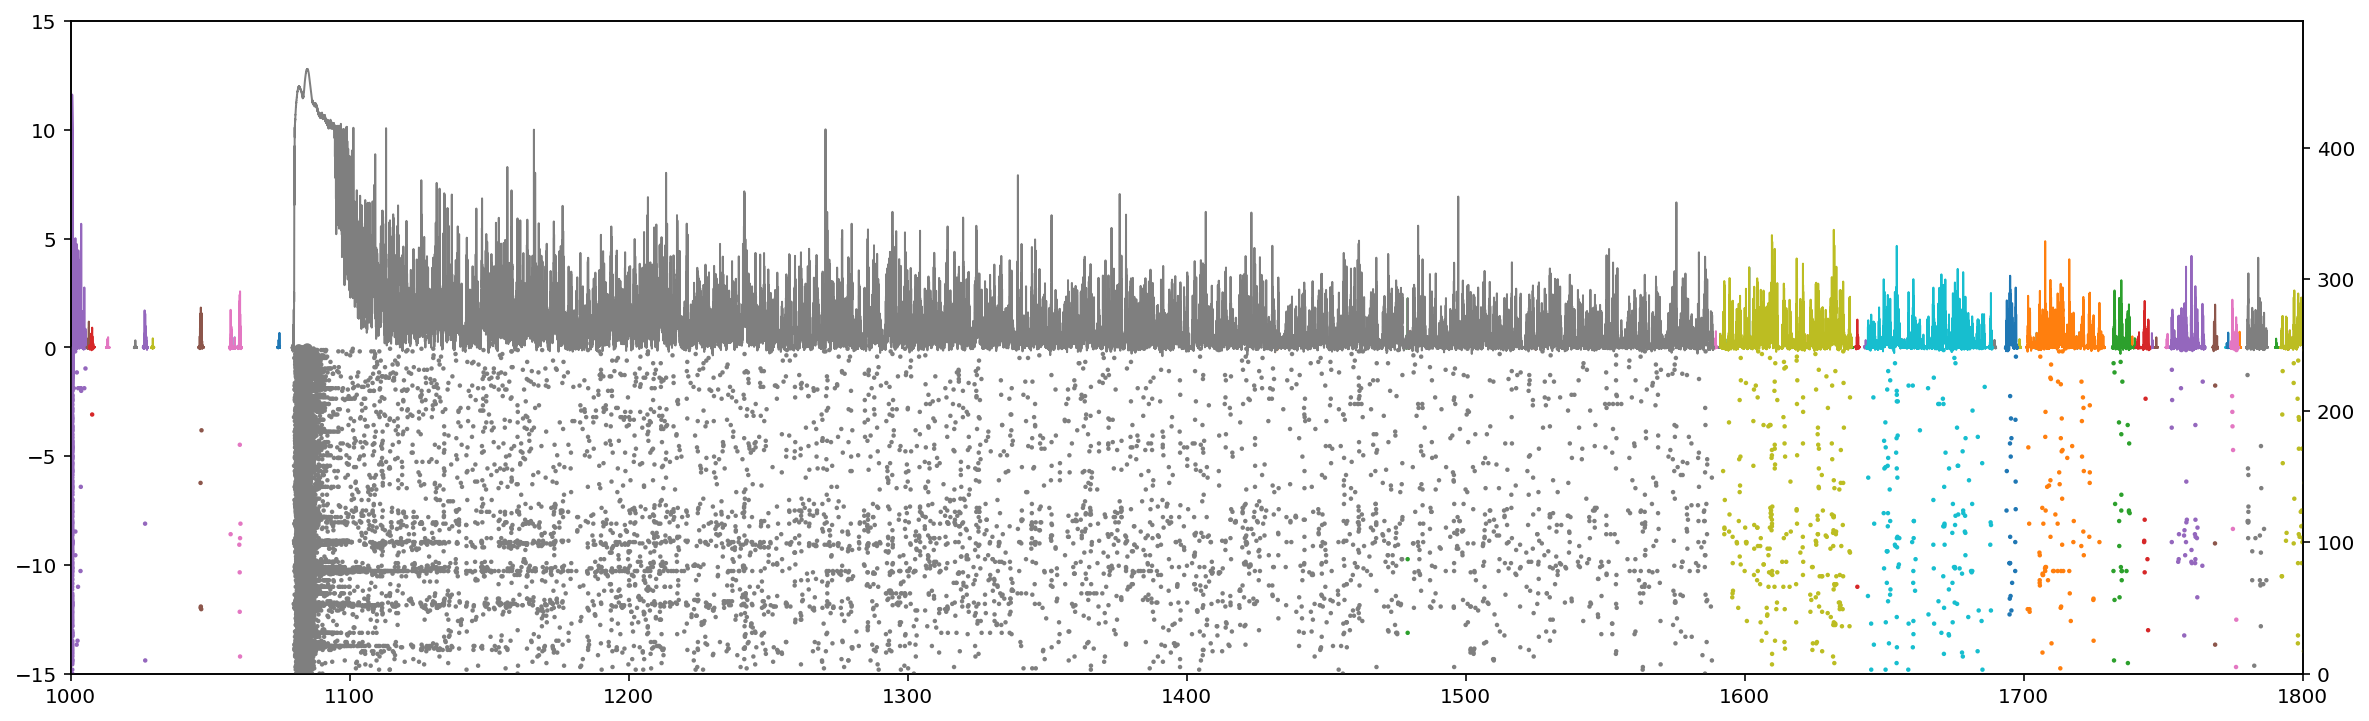

MyLocalMinimumClustering


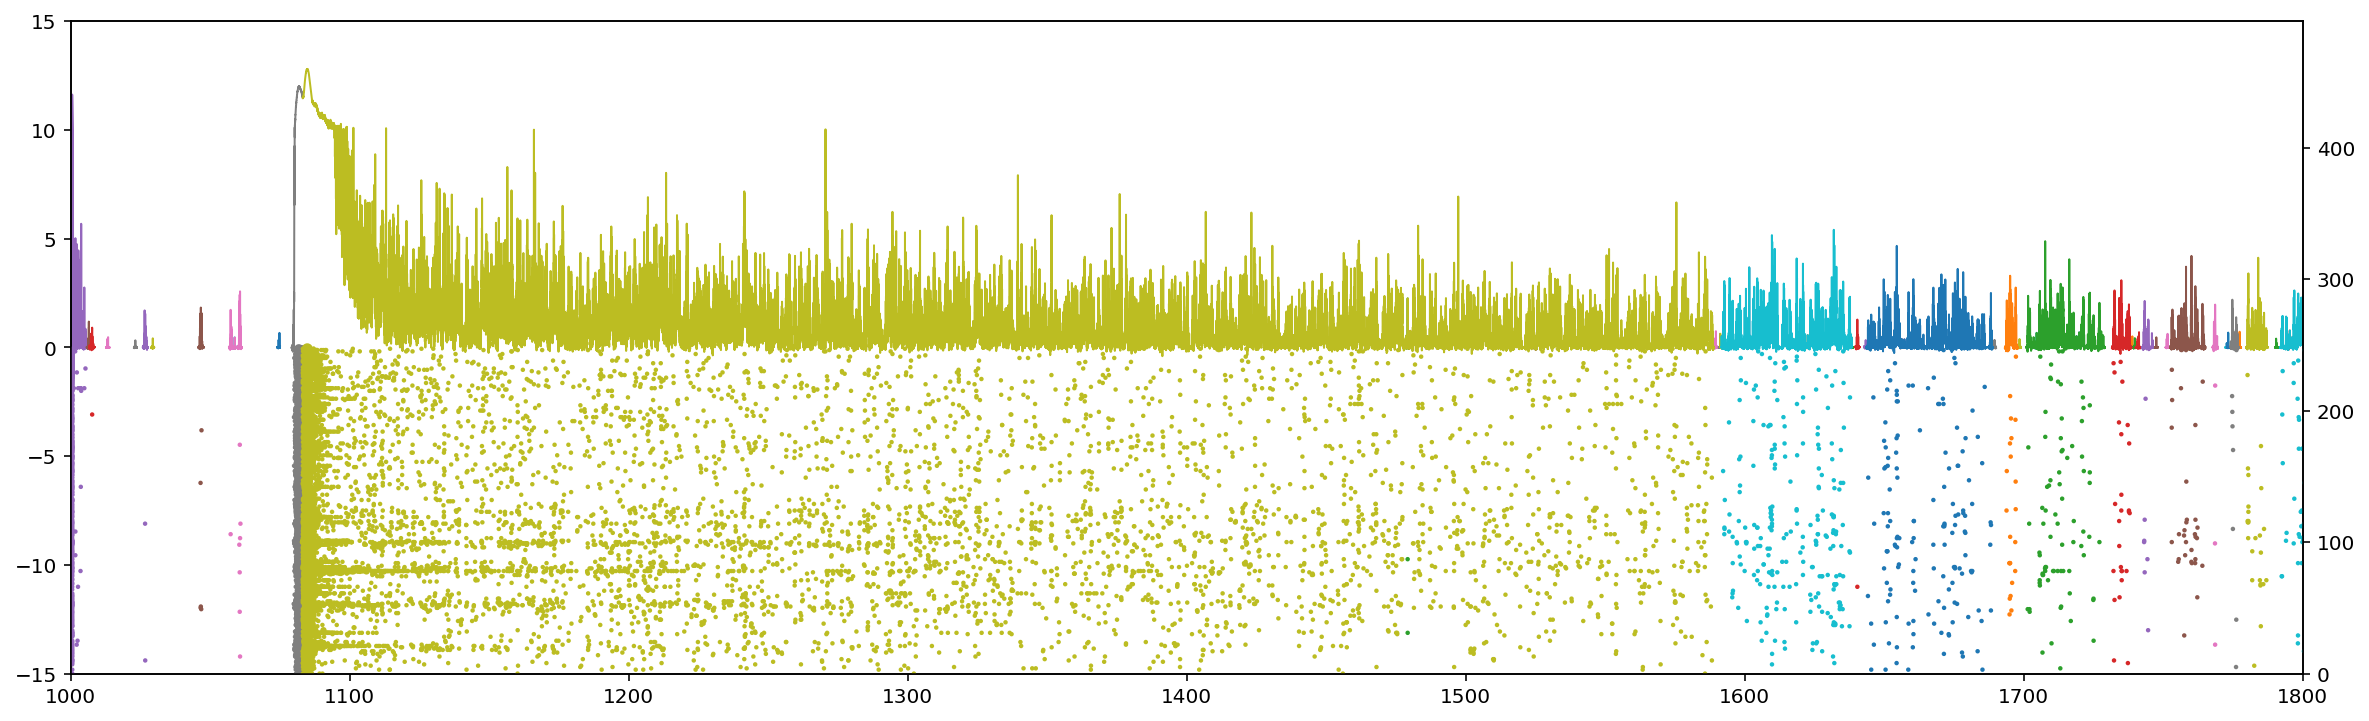

MyTailSeparation


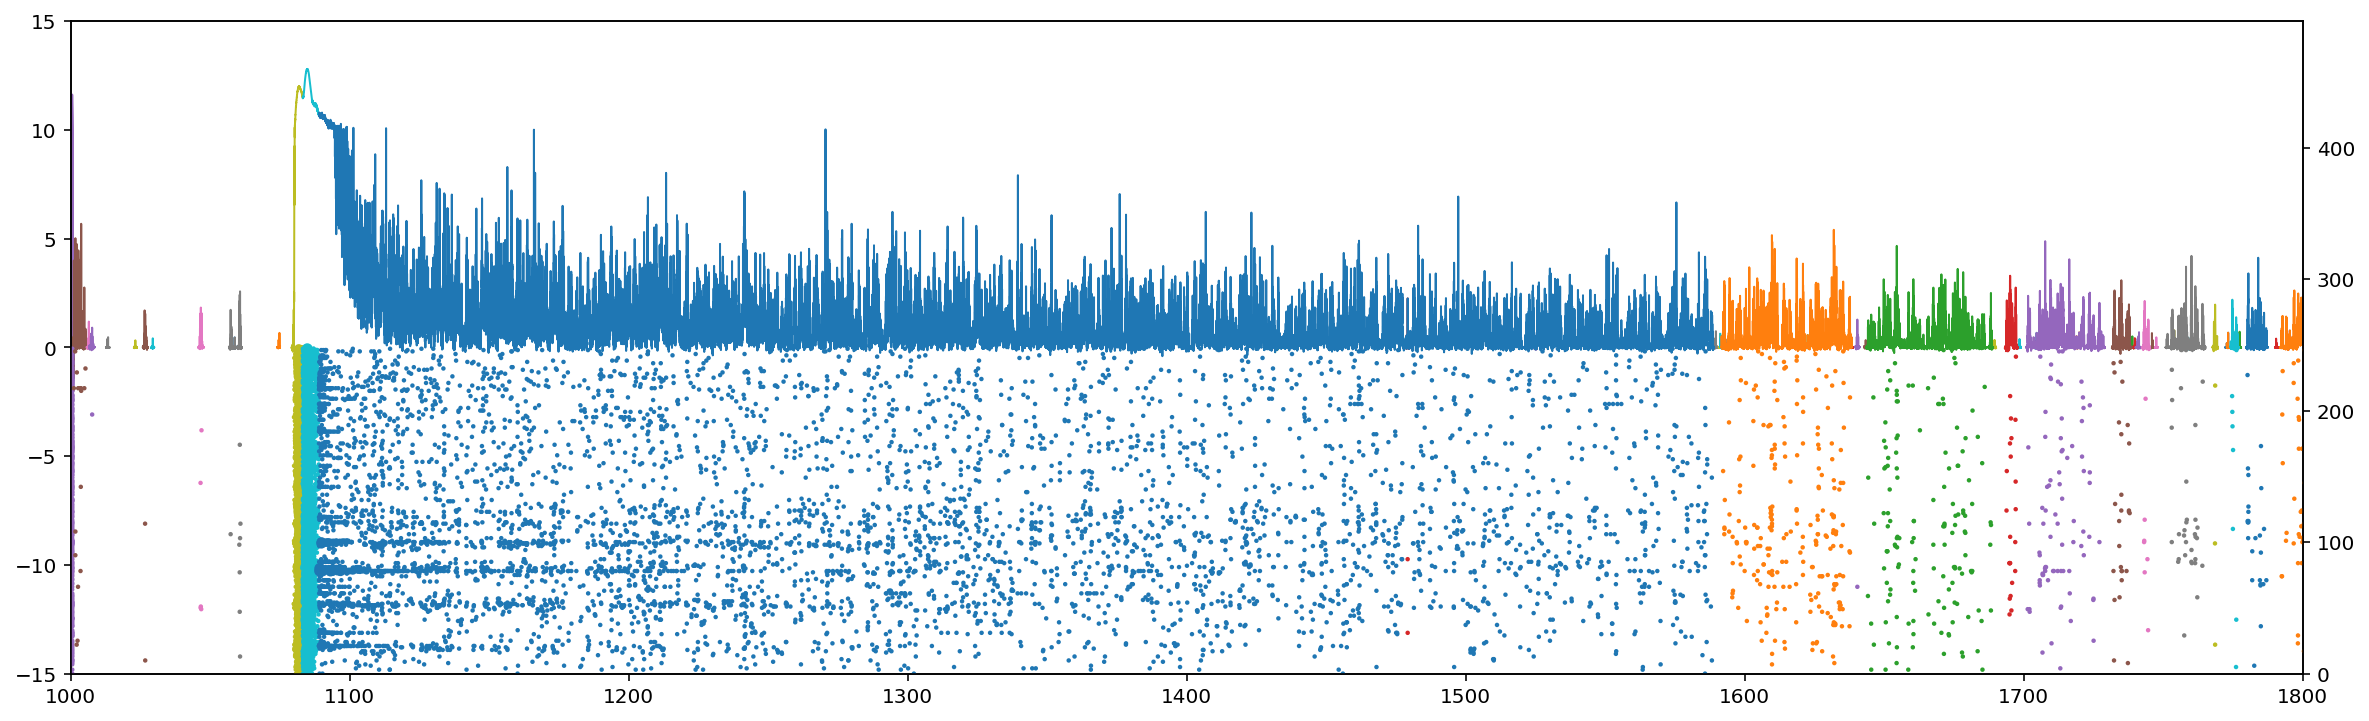

NaturalBreaksClustering


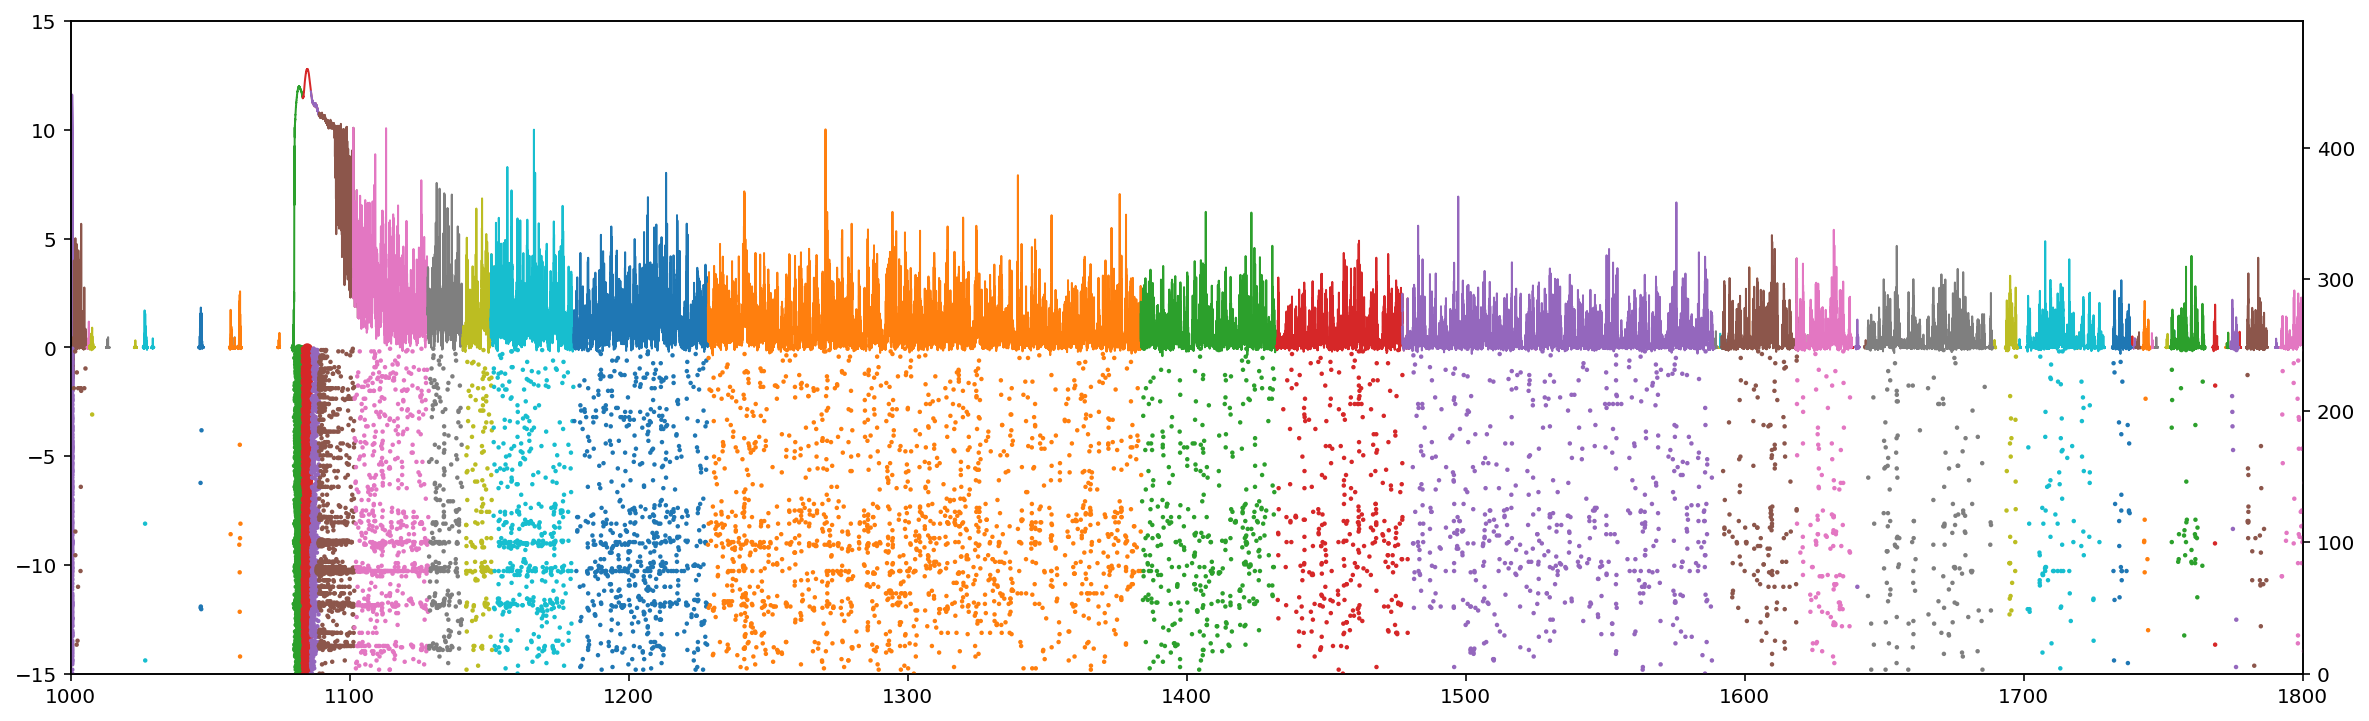

In [33]:
"""
One little trick is that the sum waveform is linear from 0-10 pe, log scale above 10.
"""
skip=0  #hax.raw_data.raw_events return a generator, I just use skip to choose which event to look
events = hax.raw_data.raw_events(my_dataset, event_numbers = df_long.event_number)
for i in range(skip+1): event = next(events)

CAPTURE = [] # Remember, this is my backdoor to take something out.
p = SignalProcessing(config_values, 0)
event = p.transform_event(event, switch_out=True,  xlim=[1000, 1800]) # xlim is just for plotting range.

processor MainProcess L66 INFO This is PAX version 6.9.0, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw_for_waveforms/170419_0228/XENON1T-8861-000000000-000000999-000001000.zip (number 1/20 in folder) for reading


['CheckPulses.SortPulses',
 'PulseProperties.PulseProperties',
 'CheckPulses.CheckBoundsAndCount',
 'DesaturatePulses.DesaturatePulses',
 'HitFinder.FindHits',
 'SumWaveform.SumWaveform',
 'BuildPeaks.GapSizeClustering',
 'RejectNoiseHits.RejectNoiseHits',
 'LocalMinimumClustering.LocalMinimumClustering',
 'NaturalBreaksClustering.NaturalBreaksClustering']
FindHits
SumWaveform
GapSizeClustering


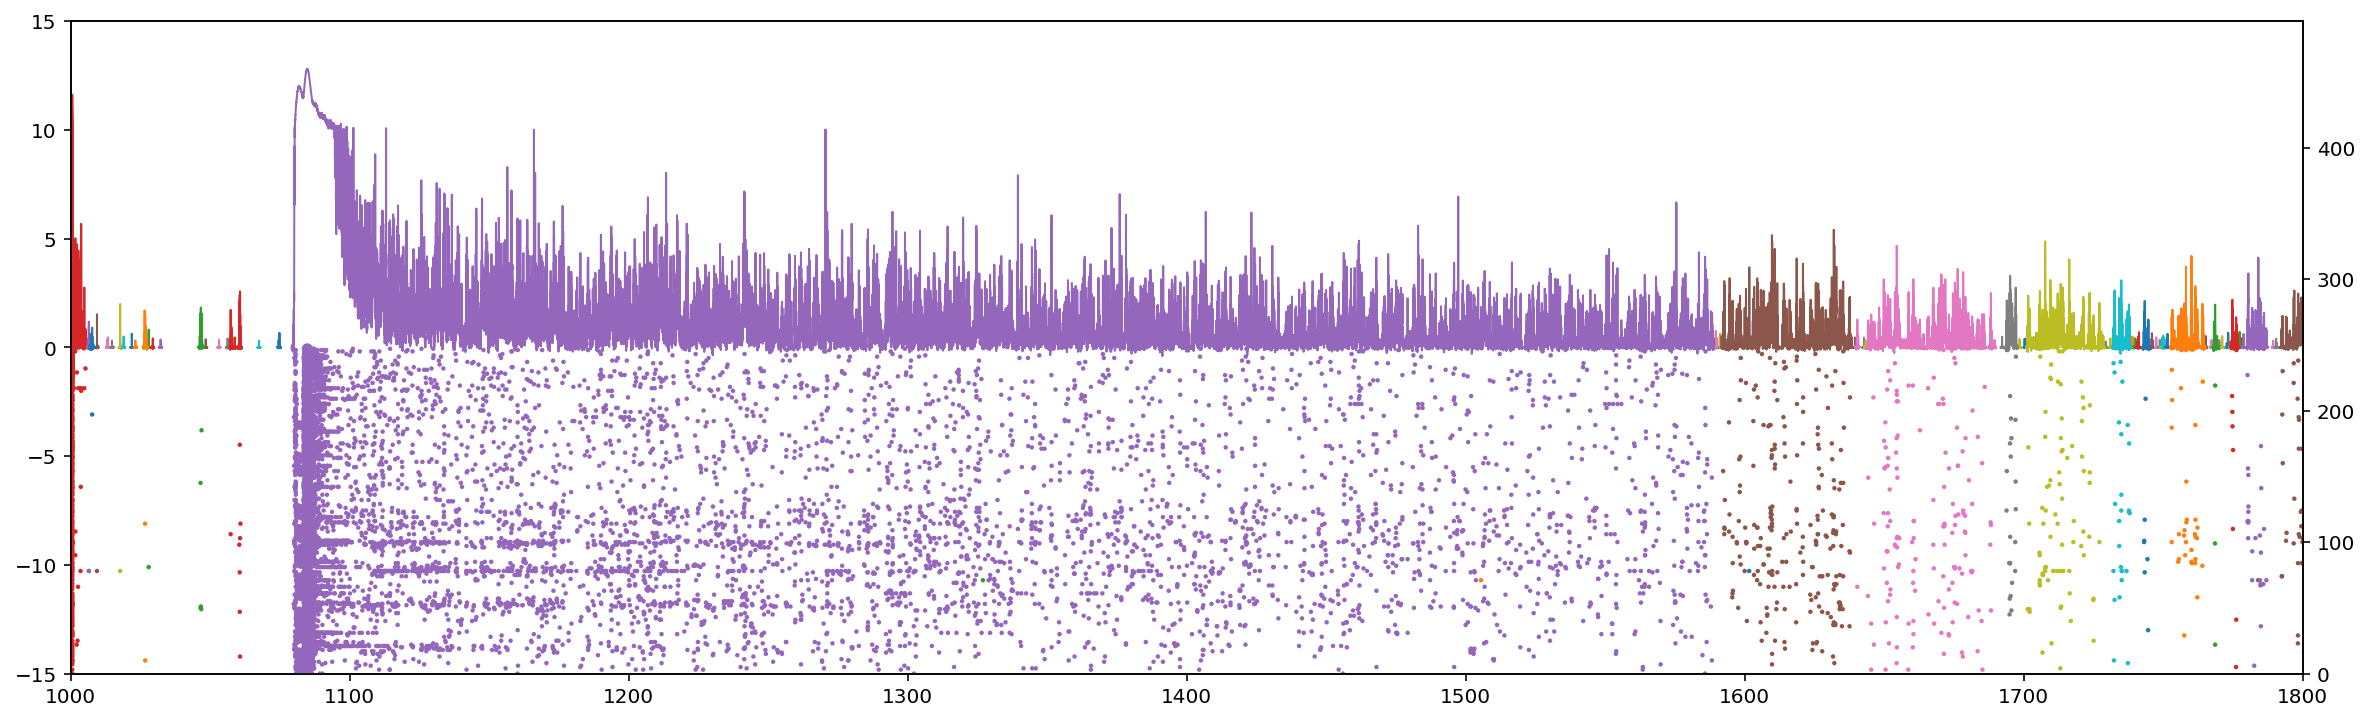

RejectNoiseHits


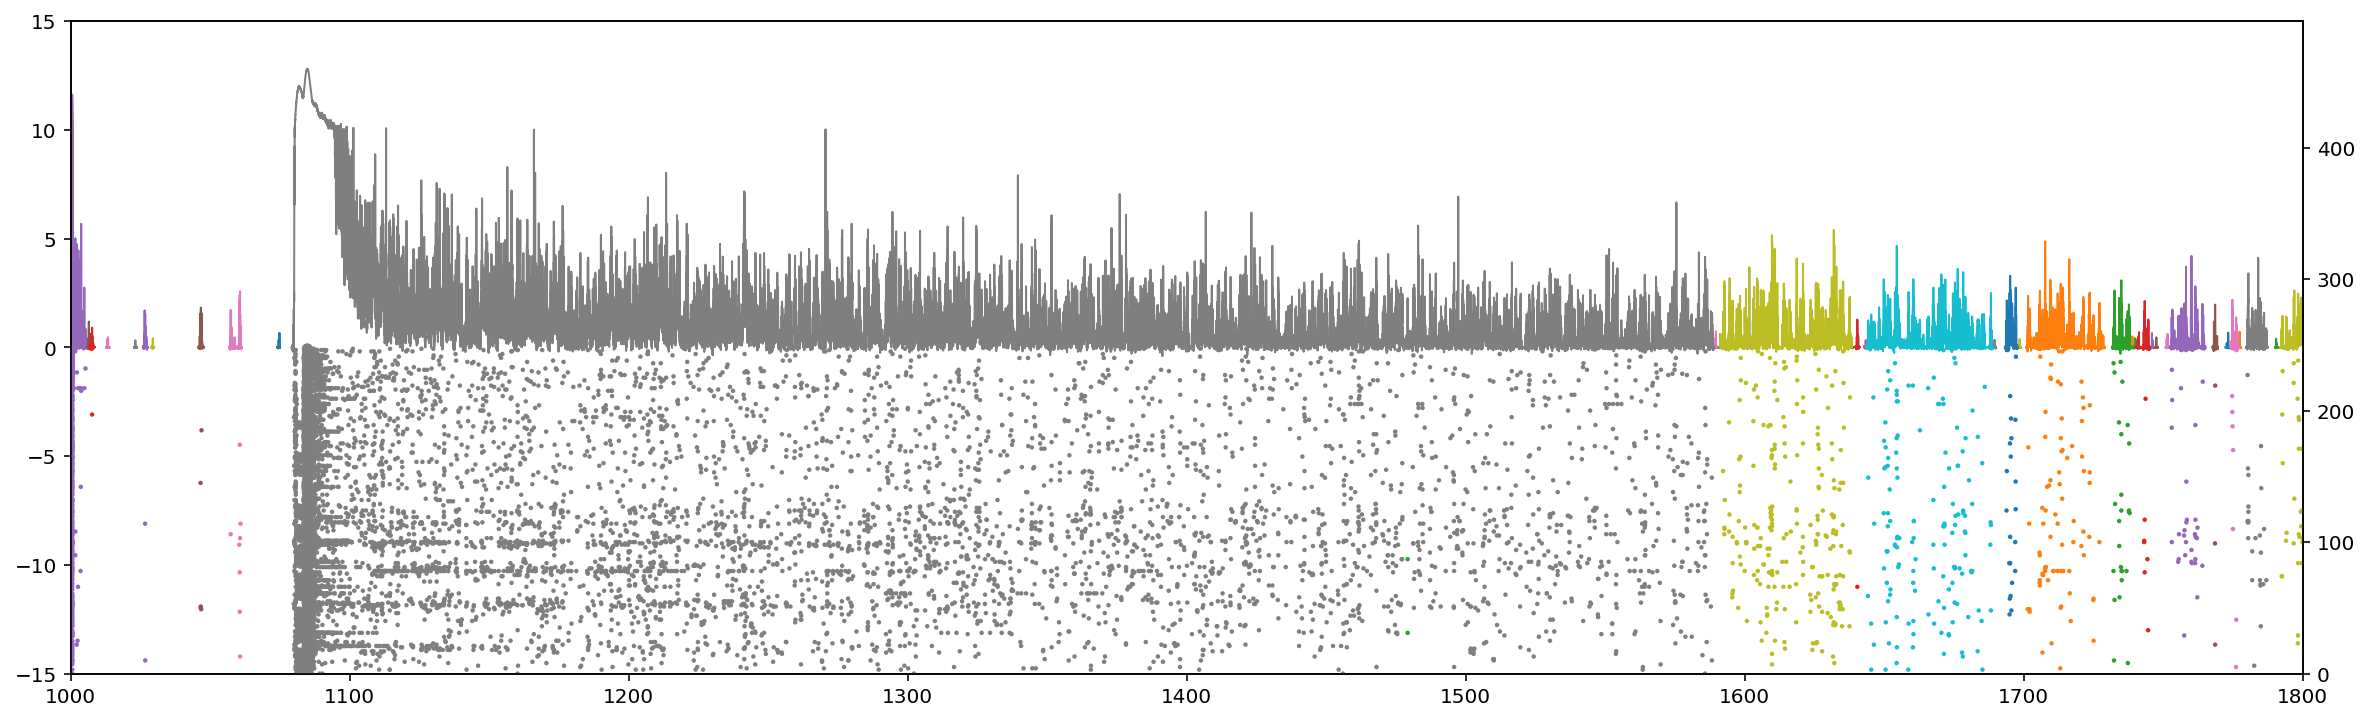

LocalMinimumClustering


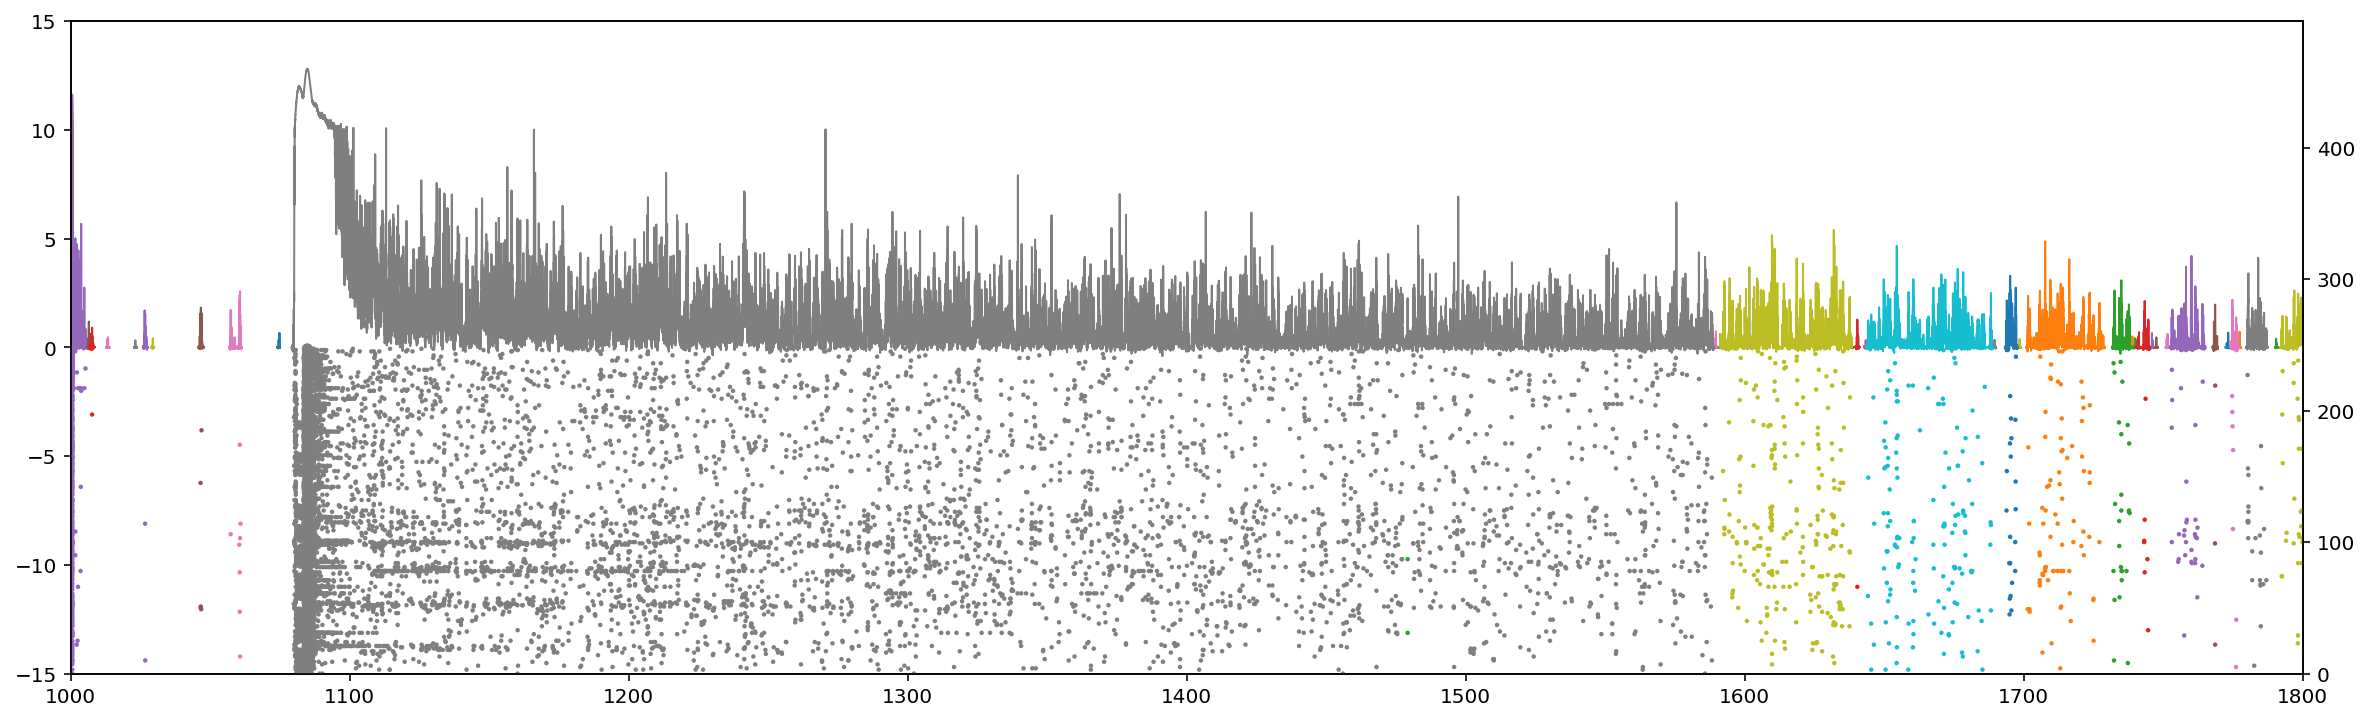

NaturalBreaksClustering


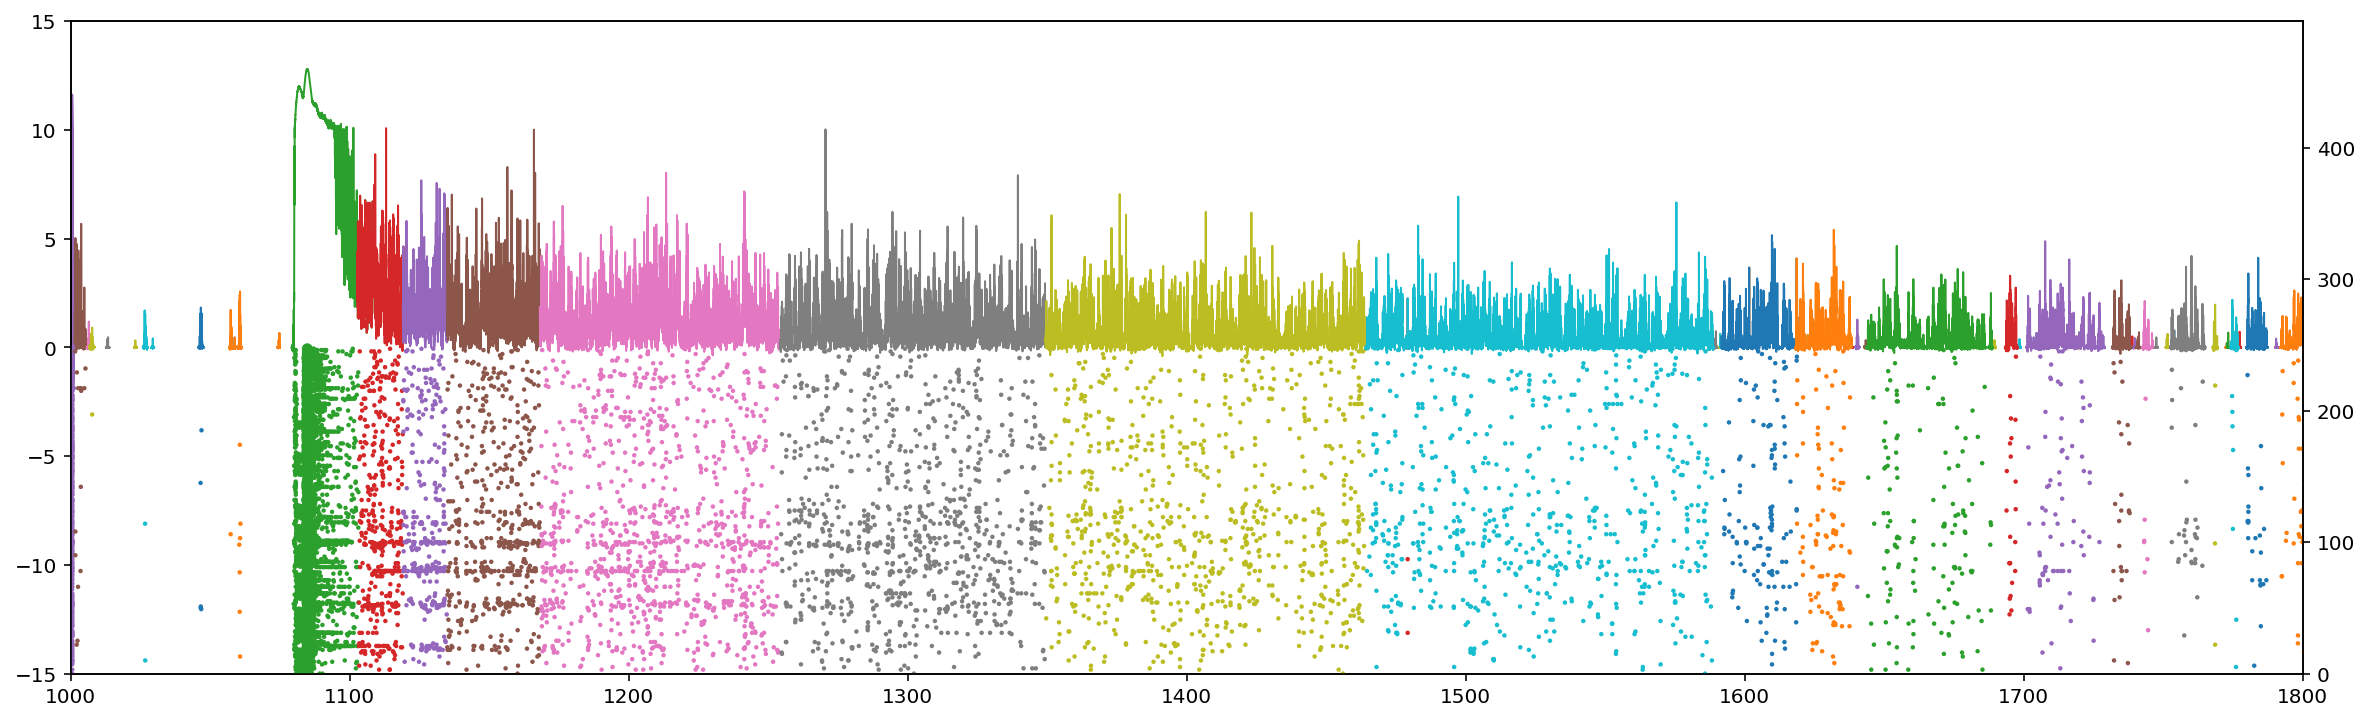

In [18]:
# Run the same event but switch_out = False
skip=0  #hax.raw_data.raw_events return a generator, I just use skip to choose which event to look
events = hax.raw_data.raw_events(my_dataset, event_numbers = df_long.event_number)
for i in range(skip+1): event = next(events)

CAPTURE = [] # Remember, this is my backdoor to take something out.
p = SignalProcessing(config_values, 0)
event = p.transform_event(event, switch_out=False,  xlim=[1000, 1800]) # xlim is just for plotting range.

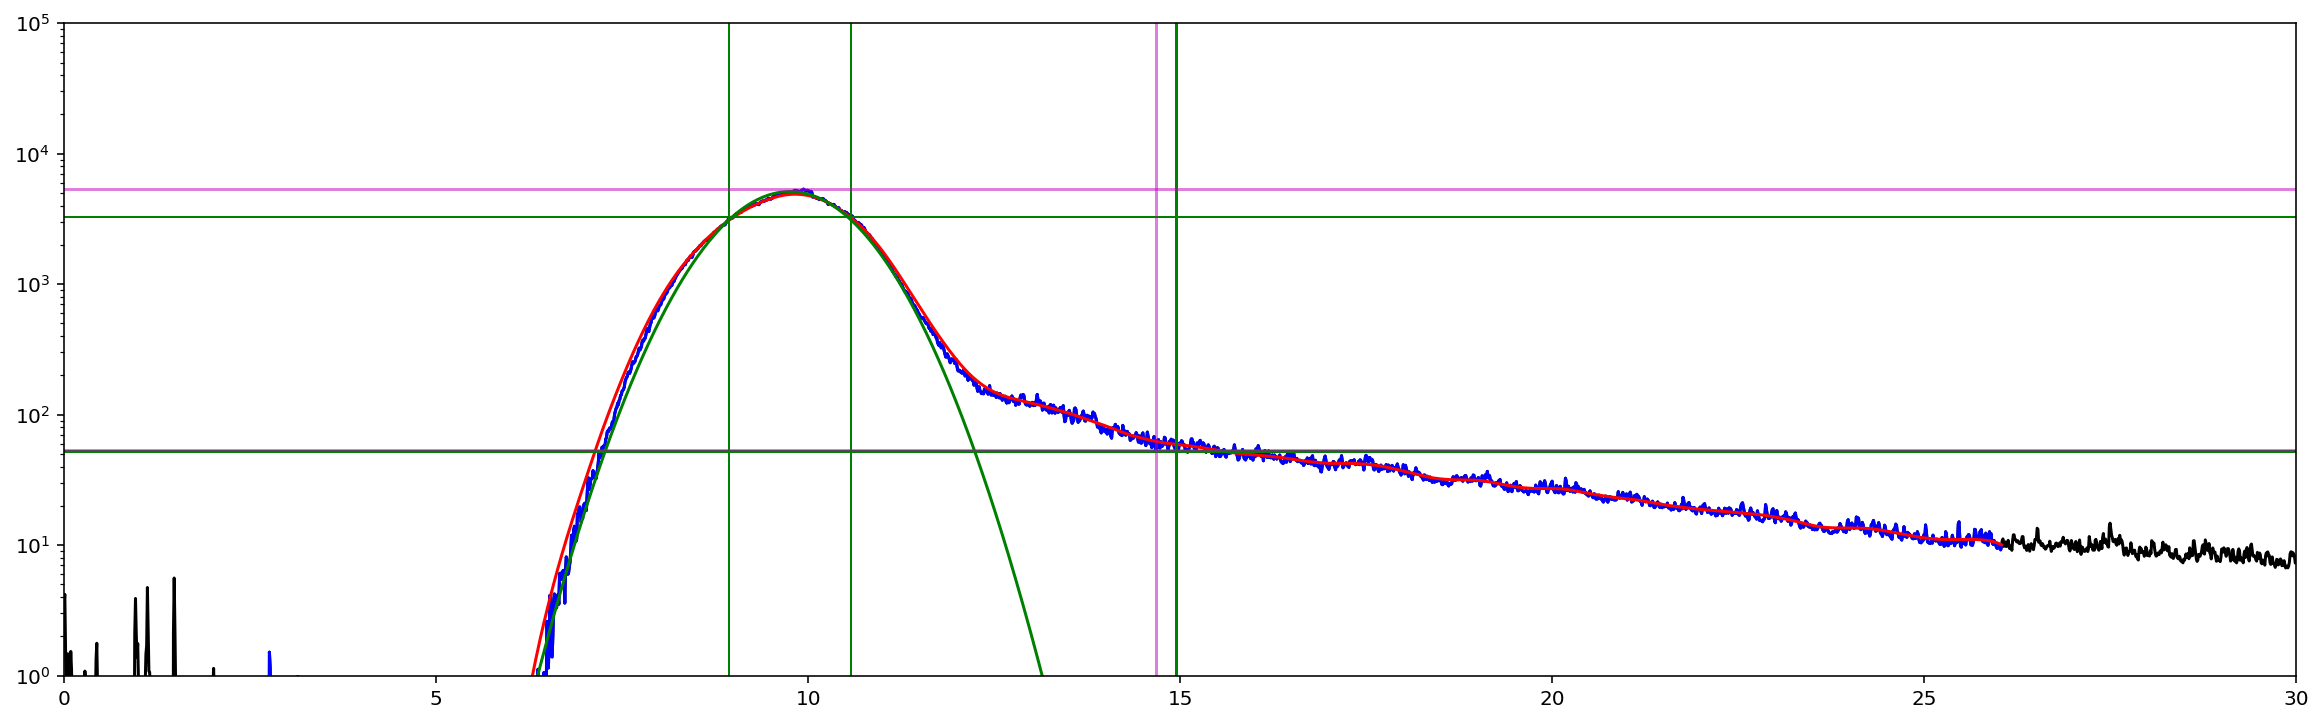

In [194]:
# Exploit my back door, the CAPTURE (in this case the sum waveform of an event)


from scipy.stats import norm
def gaussian(x, amp, mu, sigma):
    return amp * norm.pdf(x, loc=mu, scale=sigma)


with initiate_plot(20,6):
    w = CAPTURE.copy()
    x = np.arange(len(w))
    min_height=25
    
    plt.plot(x/100, w, color='k')
    
    left = np.clip(np.where(w>min_height)[0][0]-500, 0, np.inf)
    right = np.clip(np.where(w>min_height)[0][-1]+500, 0, len(w))

    plt.plot(x[left:right]/100, w[left:right], color='b')
    
    _w = smooth_lowess(w[left:right], np.arange(right-left), frac = 60/(right-left))
    plt.plot(x[left:right]/100, _w, color='r')
    
    dw = np.diff(_w, n=1)
    minima = np.where((np.hstack((dw, -1)) > 0) & (np.hstack((1, dw)) <= 0))[0]
    maxima = np.where((np.hstack((dw, 1)) < 0) & (np.hstack((-1, dw)) >= 0))[0]
    
    minima = minima[(minima>maxima[0]) & (minima<maxima[-1])]
    
    good_minima = [minima[ix]+left for ix in range(len(minima)) \
        if ((_w[maxima][ix+1] - _w[minima][ix] > config_values['min_height']) \
            & any(_w[maxima][:ix+1] - _w[minima][ix] > config_values['min_height']))]
    
    #for ix in x[minima]:plt.axvline(int(ix+left)/100, color='b', ls='--')
    #for ix in x[maxima]:plt.axvline(int(ix+left)/100, color='m', ls='--')
    #for ix in x[good_minima]:plt.axvline(int(ix+left)/100, color='green', ls='-')
        
    for jx, gw in enumerate(np.split(w, good_minima)):
        #plt.axhline(np.max(gw), color='r')
        
        cnt = gw>0.05*np.max(gw)
        
        # Quick Fit
        xs = np.arange(len(gw))
        mean = np.sum(xs[cnt]*gw[cnt])/np.sum(gw[cnt])
        sigma = (np.sum((xs[cnt]-mean)**2*gw[cnt])/np.sum(gw[cnt]))**0.5
        amp = np.sum(gw[cnt]*gaussian(xs[cnt],1,mean,sigma))/np.sum(gaussian(xs[cnt],1,mean,sigma)**2)

        plt.plot(xs/100, gaussian(xs, amp, mean, sigma), color = 'g')
        
        plt.axhline(np.max(gw)*np.exp(-0.5), color = 'g', lw=1)
        plt.axvline((mean-sigma)/100, color = 'g', lw=1)
        plt.axvline((mean+sigma)/100, color = 'g', lw=1)
        
        c = np.where(gw<5e-5*amp)[0]
        c = c[c>mean]
        if len(c)>0:plt.axvline(c[0]/100, color = 'g')
        plt.axhline(5e-5*amp, color='g')
        
        c = np.where(gw<0.01*np.max(gw))[0]
        c = c[c>np.argmax(gw)]
        if len(c)>0:plt.axvline(c[0]/100, color='m', alpha=0.5)
        plt.axhline(0.01*np.max(gw), color='m', alpha=0.5)
        plt.axhline(np.max(gw), color='m', alpha=0.5)
    
    plt.yscale('log')
    plt_config(xlim=[0, 30], ylim=[1, 1e5])